<a href="https://colab.research.google.com/github/brytlao/Practical_computer_vision/blob/master/CHAPTER_06_Feature_Based_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 06: Feature-Based Object Detection**

Discussion and demo on object detection.

# **Datasets and libraries required**

In [1]:
# tensorflow
import tensorflow as tf

# helper libraries
import numpy as np
import matplotlib.pyplot as plt

# print tf version
print(tf.__version__)

1.13.1


In [0]:
# additional dependencies
import cv2
import time
import random

In [3]:
# load tf object detection API
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
Selecting previously unselected package python-bs4.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Note: These additional steps are necessary because the model being loaded is not part of the official modules

**Load images**

In [5]:
# upload file using explorer
from google.colab import files
uploaded = files.upload()
for k, v in uploaded.items():
  open(k, 'wb').write(v)
img_name = list(uploaded)[0]

# read an image from file
img1 = cv2.imread(img_name)
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)

Saving traffic.png to traffic.png


In [6]:
# upload file using explorer
from google.colab import files
uploaded = files.upload()
for k, v in uploaded.items():
  open(k, 'wb').write(v)
img_name = list(uploaded)[0]

# read an image from file
img2 = cv2.imread(img_name)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

Saving person1.PNG to person1.PNG


# **Introduction to object detection**

**Generic image recognition**

*   classification: class name
*   classification+localization: bounding box
*   object detection: multiple bounding boxes
*   instance segmentation: multiple bounding shapes


**Challenges in object detection**

*   occlusion
*   viewpoint changes
*   variation in sizes
*   non-rigid objects
*   motion  blur

# **Methods for object detection**

**Plotting helper function**

In [0]:
# helper function
def show_mpl_img_with_detections(input_img,dets,scores,
                                 classes,category_index,
                                 thres=0.6):
  """
  apply thresholding to each box score
  plot bbox results on image
  arg:
    input_img: input image as numpy array
    dets: list of detection outputs (size: [1,K])
    scores: list of detection scores (size: [1,K])
    classes: list of predicted class indices (size: [1,K])
    category_index: dictionary with mapping from class index to class name
    thres: threshold to filter detection boxes (default: 0.6)
    default K: 100 detections
  """
  # set figure params
  FIG_WIDTH = 6
  FIG_HEIGHT = 4
  plt.figure(figsize=(FIG_WIDTH,FIG_HEIGHT))
  
  # plot original image
  plt.imshow(input_img)
  
  # plotting utilities from matplotlib
  height = input_img.shape[0]
  width = input_img.shape[1]
  colors = dict()
  
  # iterate over all proposed bbox
  for i in range(dets.shape[0]):
    cls_id = int(classes[i])
    # in case of any wrong prediction for class index
    if cls_id >= 0:
      score = scores[i]
      # score for a detection is more than a threshold
      if score > thres:
        if cls_id not in colors:
          colors[cls_id] = (random.random(),
                            random.random(),
                            random.random())
        xmin = int(dets[i,1] * width)
        ymin = int(dets[i,0] * height)
        xmax = int(dets[i,3] * width)
        ymax = int(dets[i,2] * height)
        rect = plt.Rectangle((xmin,ymin),xmax-xmin,
                             ymax-ymin,fill=False,
                             edgecolor=colors[cls_id],
                             linewidth=2.5)
        plt.gca().add_patch(rect)
        # plot class name and score around each detection box
        class_name = str(category_index[cls_id]['name'])
        plt.gca().text(xmin,ymin-2,'{:s} {:.3f}'.format(class_name,score),
                       bbox=dict(facecolor=colors[cls_id],alpha=0.5),
                       fontsize=8, color='white')
  plt.axis('off')
  plt.show()
  
  return

**Two-stage detector: Faster R-CNN with ResNet-101**

In [0]:
MODEL = 'faster_rcnn_resnet101_coco_2017_11_08'

In [9]:
# load model resources
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_frcnn'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [0]:
# load graph
def load_and_create_graph(path_to_pb):
  """
  loades pre-trained graph from .pb file
  path_to_pb: path to saved .pb file
  note: graph is global. no return
  """
  with tf.gfile.GFile(path_to_pb,'rb') as f:
    # init graph definition
    graph_def = tf.GraphDef()
    
    # read file
    graph_def.ParseFromString(f.read())
    
    # import as tf.graph
    _ = tf.import_graph_def(graph_def,name='')

In [0]:
# load pretrained model
load_and_create_graph('pretrained_frcnn/frozen_inference_graph.pb')

In [0]:
# load labels
path_to_labels = os.path.join('/content',
                              'models',
                              'research',
                              'object_detection',
                              'data',
                              'mscoco_label_map.pbtxt')

# set pretraining parameters
num_classes = 90
label_map = label_map_util.load_labelmap(path_to_labels)
categories = label_map_util.convert_label_map_to_categories(
    label_map,max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
# create graph object from previously loaded graph
graph = tf.get_default_graph()

In [14]:
# launch a session to run this graph
with tf.Session(graph=graph) as sess:
  # get input node
  image_tensor = graph.get_tensor_by_name('image_tensor:0')
  
  # get output nodes
  detection_boxes = graph.get_tensor_by_name('detection_boxes:0')
  detection_scores = graph.get_tensor_by_name('detection_scores:0')
  detection_classes = graph.get_tensor_by_name('detection_classes:0')
  num_detections = graph.get_tensor_by_name('num_detections:0')
  
  # read image from file and pre-process it for input.
  input_img = img1[np.newaxis, :, :, :]
  
  # run prediction and get 4 outputs
  start = time.time()
  (boxes,scores,classes,num) = sess.run(
      [detection_boxes,detection_scores,detection_classes,num_detections],
      feed_dict={image_tensor: input_img})
  end = time.time()
  
  print("Prediction time:",end-start,"secs for ",num[0],"detections")

Prediction time: 14.68654179573059 secs for  300.0 detections


In [0]:
%matplotlib inline

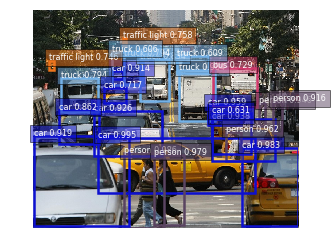

In [17]:
# display results
show_mpl_img_with_detections(img1,boxes[0],scores[0],classes[0],
                             category_index,thres=0.6)

**One-stage detector: Single Shot Multibox Detector**

In [0]:
MODEL = 'ssd_inception_v2_coco_2017_11_17'

In [19]:
# load model resources
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_ssd'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [0]:
# load pre-trained model
load_and_create_graph('pretrained_ssd/frozen_inference_graph.pb')

In [0]:
# load labels
path_to_labels = os.path.join('/content',
                              'models',
                              'research',
                              'object_detection',
                              'data',
                              'mscoco_label_map.pbtxt')

# set pretraining parameters
num_classes = 90
label_map = label_map_util.load_labelmap(path_to_labels)
categories = label_map_util.convert_label_map_to_categories(
    label_map,max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
# create graph object from previously loaded graph
graph = tf.get_default_graph()

In [23]:
# launch a session to run this graph
with tf.Session(graph=graph) as sess:
  # get input node
  image_tensor = graph.get_tensor_by_name('image_tensor:0')
  
  # get output nodes
  detection_boxes = graph.get_tensor_by_name('detection_boxes:0')
  detection_scores = graph.get_tensor_by_name('detection_scores:0')
  detection_classes = graph.get_tensor_by_name('detection_classes:0')
  num_detections = graph.get_tensor_by_name('num_detections:0')
  
  # read image from file and pre-process it for input.
  input_img = img2[np.newaxis, :, :, :]
  
  # run prediction and get 4 outputs
  start = time.time()
  (boxes, scores, classes, num) = sess.run(
      [detection_boxes,detection_scores,detection_classes,num_detections],
      feed_dict={image_tensor: input_img})
  end = time.time()
  
  print("Prediction time:",end-start,"secs for ",num,"detections")

Prediction time: 8.584564208984375 secs for  [300.] detections


In [0]:
%matplotlib inline

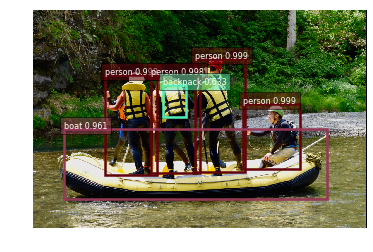

In [25]:
# display results
show_mpl_img_with_detections(img2,boxes[0],scores[0],classes[0],
                             category_index,thres=0.6)